<div style="display:block;width:100%;margin:auto;" direction=rtl align=center><br><br>
    <div  style="width:100%;margin:100;display:block;background-color:#fff0;"  display=block align=center>
        <table style="border-style:hidden;border-collapse:collapse;">             <tr>
                <td  style="border: none!important;">
                    <img width=130 align=right src="https://i.ibb.co/yXKQmtZ/logo1.png" style="margin:0;" />
                </td>
                <td style="text-align:center;border: none!important;">
                    <h1 align=center><font size=5 color="#045F5F"> <b>Armin Ghasemi</b><br><br>810100198</i></font></h1>
                </td>
                <td style="text-align:center;border: none!important;">
                    <h1 align=center><font size=5 color="#045F5F"> <b>deep learning </b><br><br>HW_6 Q2</i></font></h1>
                </td>
                <td style="text-align:center;border: none!important;">
                    <h1 align=center><font size=5 color="#045F5F"> <b>Amirhossein samoudi </b><br><br>810100108</i></font></h1>
                </td>
                <td style="border: none!important;">
                    <img width=170 align=left  src="https://i.ibb.co/wLjqFkw/logo2.png" style="margin:0;" />
                </td>
           </tr>
        </table>
    </div>
</div>


### imports

In [ ]:
!pip install kaggle

from google.colab import files
import glob
import shutil
import random
from PIL import Image
import matplotlib.pyplot as plt
import cv2
import numpy as np
import os
from tqdm.notebook import tqdm
from google.colab import drive
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import pandas as pd

### mount drive

In [2]:
drive.mount('/content/drive')

Mounted at /content/drive


### Data preprocessing

In [ ]:
# --- 1. Install Kaggle and Setup API Key ---
# This will only prompt for upload if the key is not found
if not os.path.exists("/root/.kaggle/kaggle.json"):
    print("Installing Kaggle library...")
    !pip install -q kaggle

    print("\nPlease upload your kaggle.json file:")
    !mkdir -p ~/.kaggle
    uploaded = files.upload()
    for fn in uploaded.keys():
        !mv {fn} ~/.kaggle/
    !chmod 600 ~/.kaggle/kaggle.json
    print("\nKaggle API key configured successfully.")


# --- 2. Download and Extract Dataset (if it doesn't exist) ---
dataset_dir = './kvasir-dataset'

if not os.path.exists(dataset_dir):
    print(f"Dataset directory '{dataset_dir}' not found.")
    print("Downloading dataset from Kaggle...")
    # This command downloads the zip file
    !kaggle datasets download -d meetnagadia/kvasir-dataset

    print("\nUnzipping files...")
    # This command extracts the zip into the target directory
    !unzip -q kvasir-dataset.zip -d {dataset_dir}
    print("Dataset successfully extracted.")

    # Optional: remove the zip file to save space
    !rm kvasir-dataset.zip

else:
    print(f"Dataset directory '{dataset_dir}' already exists. Skipping download and extraction.")


# --- 3. List the contents of the image directory ---
# Based on your screenshot, the actual image folders are one level deeper.
print("\nContents of the dataset directory:")
!ls ./kvasir-dataset/kvasir-dataset

Dataset directory './kvasir-dataset' already exists. Skipping download and extraction.

Contents of the dataset directory:
dyed-lifted-polyps	esophagitis   normal-pylorus  polyps
dyed-resection-margins	normal-cecum  normal-z-line   ulcerative-colitis


Created directory: ./final_dataset/normal
Created directory: ./final_dataset/abnormal

Copying normal images...
Copied 1500 normal images.

Copying abnormal images (polyps)...
Copied 500 abnormal images.

--- Statistical Summary ---
Total Normal Images: 1500
Total Abnormal Images: 500
---------------------------
Image dimensions (width, height) in 'normal' folder:
  - (1920, 1072): 226 images
  - (1280, 1024): 682 images
  - (720, 576): 592 images

Image dimensions (width, height) in 'abnormal' folder:
  - (720, 576): 477 images
  - (1920, 1072): 16 images
  - (1280, 1024): 7 images

Note: The variation in image sizes shows why a preprocessing step to resize all images to a standard size (e.g., 96x96 like in the paper) is necessary.

--- Sample Images ---


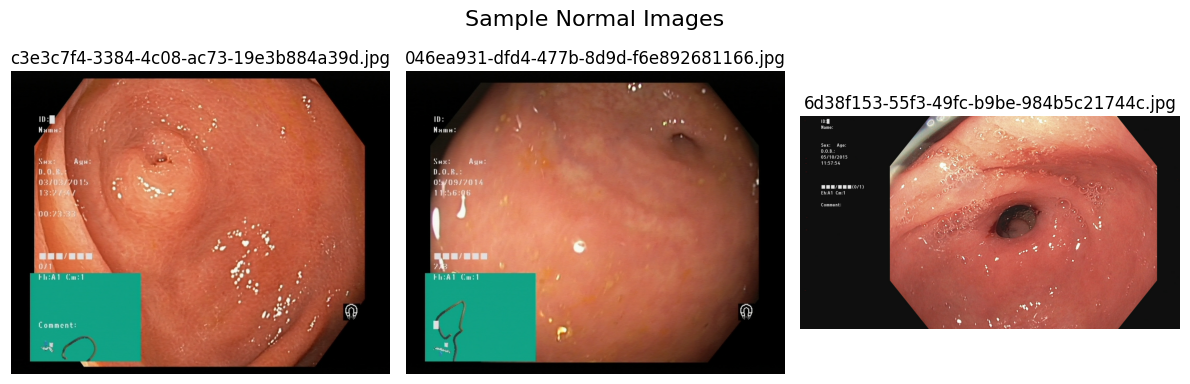

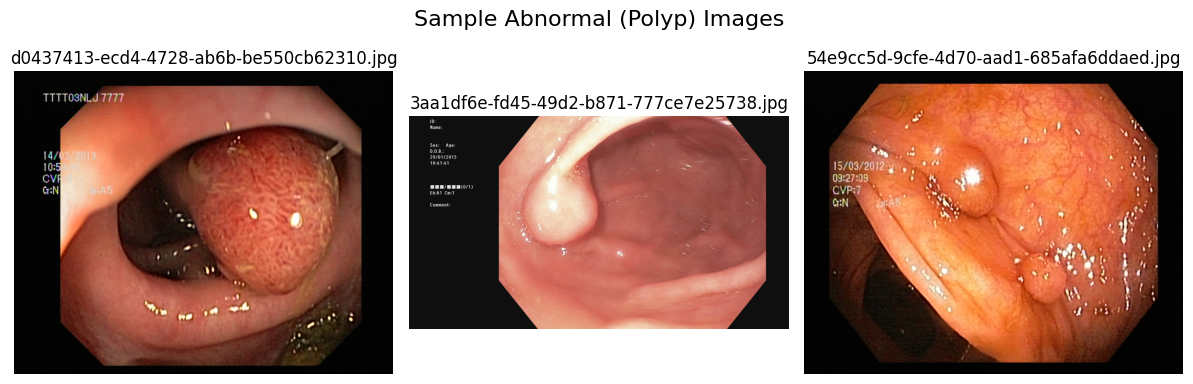

In [ ]:
# --- 1. Define Source and Destination Paths ---
base_source_dir = './kvasir-dataset/kvasir-dataset/'
dest_dir = './final_dataset'

# Source folders for "normal" class
normal_sources = ['normal-cecum', 'normal-pylorus', 'normal-z-line']
# Source folder for "abnormal" class
abnormal_sources = ['polyps']

# Destination paths
dest_normal_path = os.path.join(dest_dir, 'normal')
dest_abnormal_path = os.path.join(dest_dir, 'abnormal')

# --- 2. Create Destination Directories ---
os.makedirs(dest_normal_path, exist_ok=True)
os.makedirs(dest_abnormal_path, exist_ok=True)
print(f"Created directory: {dest_normal_path}")
print(f"Created directory: {dest_abnormal_path}")

# --- Function to copy files ---
def copy_files(source_folders, destination_folder):
    # Clear destination folder before copying to avoid duplicates on re-run
    for f in glob.glob(os.path.join(destination_folder, '*')):
        os.remove(f)

    file_counter = 0
    for folder in source_folders:
        source_path = os.path.join(base_source_dir, folder)
        image_files = glob.glob(os.path.join(source_path, '*.jpg'))
        for file_path in image_files:
            shutil.copy(file_path, destination_folder)
            file_counter += 1
    return file_counter

# --- 3. Copy Normal and Abnormal Images ---
print("\nCopying normal images...")
num_normal = copy_files(normal_sources, dest_normal_path)
print(f"Copied {num_normal} normal images.")

print("\nCopying abnormal images (polyps)...")
num_abnormal = copy_files(abnormal_sources, dest_abnormal_path)
print(f"Copied {num_abnormal} abnormal images.")

# --- 4. Statistical Summary ---
print("\n--- Statistical Summary ---")
print(f"Total Normal Images: {num_normal}")
print(f"Total Abnormal Images: {num_abnormal}")
print("---------------------------")

# Function to get image dimension variations
def get_dimension_stats(folder_path):
    from collections import Counter
    dimensions = Counter()
    image_files = glob.glob(os.path.join(folder_path, '*.jpg'))
    for img_path in image_files:
        try:
            with Image.open(img_path) as img:
                dimensions[img.size] += 1
        except Exception:
            pass # Ignore corrupted files if any
    return dimensions

normal_dims = get_dimension_stats(dest_normal_path)
abnormal_dims = get_dimension_stats(dest_abnormal_path)

print("Image dimensions (width, height) in 'normal' folder:")
for dim, count in normal_dims.items():
    print(f"  - {dim}: {count} images")

print("\nImage dimensions (width, height) in 'abnormal' folder:")
for dim, count in abnormal_dims.items():
    print(f"  - {dim}: {count} images")


# --- 5. Display Sample Images ---
def display_samples(folder_path, title, num_samples=3):
    image_files = glob.glob(os.path.join(folder_path, '*.jpg'))
    sample_files = random.sample(image_files, min(num_samples, len(image_files)))

    plt.figure(figsize=(12, 4))
    plt.suptitle(title, fontsize=16)
    for i, file_path in enumerate(sample_files):
        plt.subplot(1, num_samples, i + 1)
        img = Image.open(file_path)
        plt.imshow(img)
        plt.axis('off')
        plt.title(os.path.basename(file_path))
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

print("\n--- Sample Images ---")
display_samples(dest_normal_path, "Sample Normal Images")
display_samples(dest_abnormal_path, "Sample Abnormal (Polyp) Images")

In [ ]:
def crop_borders_adaptive(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    _, mask = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if not contours:
        return image
    largest_contour = max(contours, key=cv2.contourArea)
    x, y, w, h = cv2.boundingRect(largest_contour)
    return image[y:y+h, x:x+w]

def center_crop_and_resize(image, final_size=96):
    h, w, _ = image.shape
    crop_size = min(h, w)
    start_y = h // 2 - crop_size // 2
    start_x = w // 2 - crop_size // 2
    cropped_square = image[start_y : start_y + crop_size, start_x : start_x + crop_size]
    return cv2.resize(cropped_square, (final_size, final_size), interpolation=cv2.INTER_AREA)

# --- Main processing function with NORMALIZATION ---

def finalize_and_save_dataset(source_dir, dest_dir):
    """
    Applies the full preprocessing pipeline including normalization and saves
    the results as NumPy arrays (.npy).
    """
    if not os.path.exists(dest_dir):
        os.makedirs(dest_dir)
        print(f"Created directory: {dest_dir}")

    image_paths = glob.glob(os.path.join(source_dir, '*.jpg'))

    print(f"Processing and saving {len(image_paths)} images from {source_dir}...")
    for img_path in tqdm(image_paths):
        original_img = cv2.imread(img_path)
        if original_img is None:
            continue

        # 1. Remove bezel
        bezel_removed_img = crop_borders_adaptive(original_img)

        # 2. Center crop and resize
        resized_img = center_crop_and_resize(bezel_removed_img, final_size=96)

        # 3. Normalize to [0, 1]
        # Convert to float and divide by 255
        normalized_img = resized_img.astype(np.float32) / 255.0

        # 4. Save the result as a .npy file
        base_name = os.path.basename(img_path).replace('.jpg', '.npy')
        save_path = os.path.join(dest_dir, base_name)
        np.save(save_path, normalized_img)

    print(f"Finished. Final processed data is saved in {dest_dir}")


# --- Define final directories and run the pipeline ---
source_normal_dir = './final_dataset/normal'
source_abnormal_dir = './final_dataset/abnormal'

dest_final_normal_dir = './processed_dataset_final/normal'
dest_final_abnormal_dir = './processed_dataset_final/abnormal'

finalize_and_save_dataset(source_normal_dir, dest_final_normal_dir)
print("-" * 50)
finalize_and_save_dataset(source_abnormal_dir, dest_final_abnormal_dir)

Processing and saving 1500 images from ./final_dataset/normal...


  0%|          | 0/1500 [00:00<?, ?it/s]

Finished. Final processed data is saved in ./processed_dataset_final/normal
--------------------------------------------------
Processing and saving 500 images from ./final_dataset/abnormal...


  0%|          | 0/500 [00:00<?, ?it/s]

Finished. Final processed data is saved in ./processed_dataset_final/abnormal



--- Corrected Detailed Visualization ---

Visualizing: fa82f51d-b99b-4226-bd8f-92bdb6221d7c.jpg


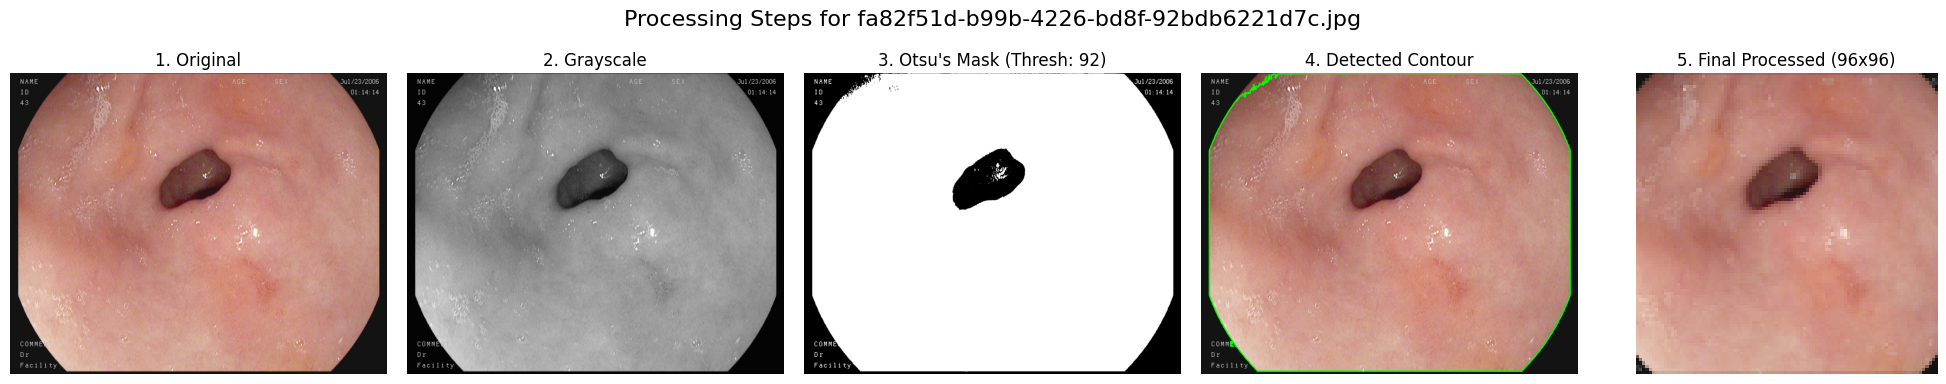


Visualizing: 8d8a4b72-68e9-4ed5-9160-32fb74fcef23.jpg


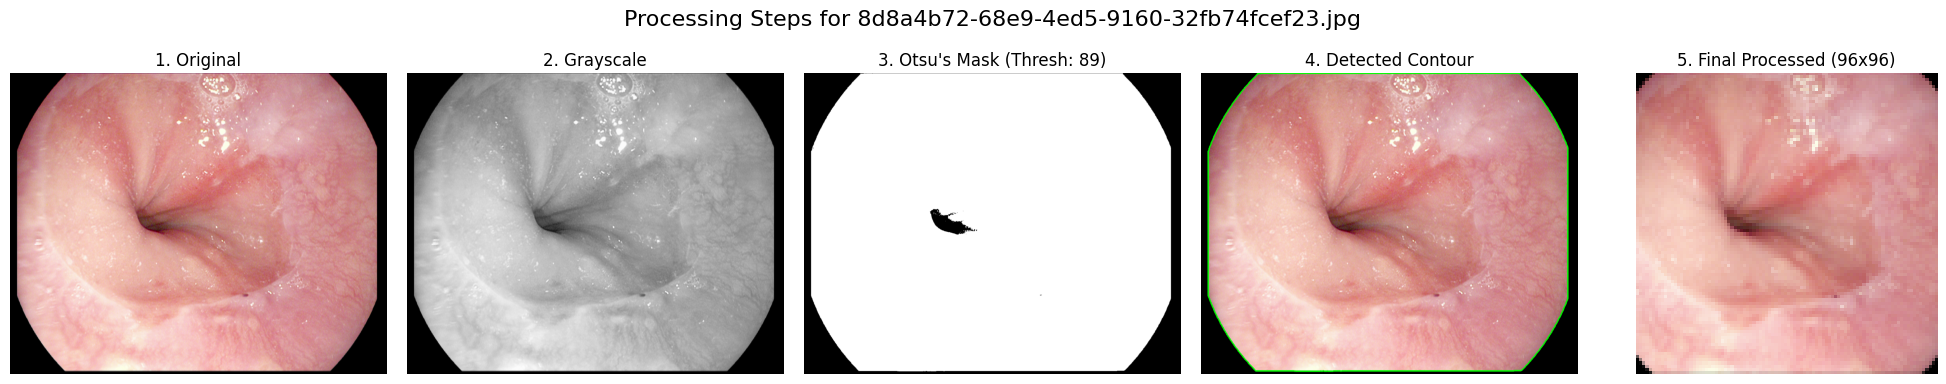


Visualizing: 74c19c0b-0437-4571-bd5a-1db60be1b34b.jpg


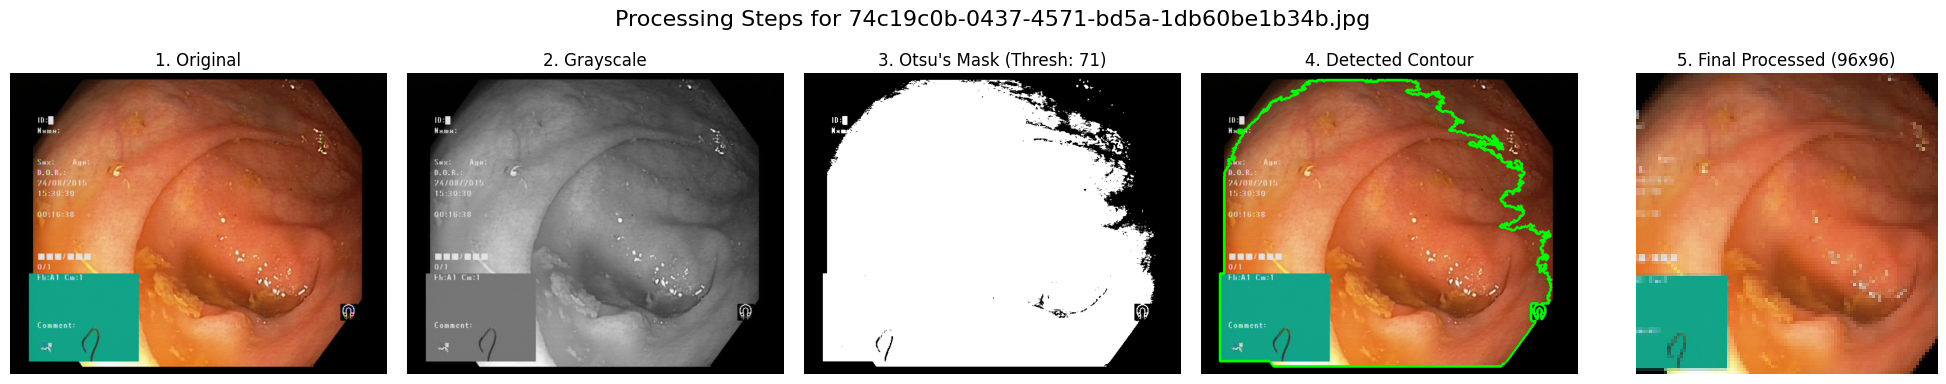

In [ ]:
print("\n--- Corrected Detailed Visualization ---")

# Use the original image paths for visualization
normal_image_files = glob.glob('./final_dataset/normal/*.jpg')

if len(normal_image_files) >= 3:
    sample_paths = random.sample(normal_image_files, 3)

    for image_path in sample_paths:
        print(f"\nVisualizing: {os.path.basename(image_path)}")

        # Load original image
        original_img = cv2.imread(image_path)
        if original_img is None:
            continue

        # Re-create all intermediate steps for the visualization
        gray = cv2.cvtColor(original_img, cv2.COLOR_BGR2GRAY)
        threshold_value, otsu_mask = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

        contours, _ = cv2.findContours(otsu_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        img_with_contour = original_img.copy()
        if contours:
            largest_contour = max(contours, key=cv2.contourArea)
            cv2.drawContours(img_with_contour, [largest_contour], -1, (0, 255, 0), 3)

        # Load the final processed .npy file to show what was actually saved
        base_name = os.path.basename(image_path).replace('.jpg', '.npy')
        processed_path = os.path.join('./processed_dataset_final/normal', base_name)
        final_processed_normalized = np.load(processed_path)


        # --- Display all steps ---
        plt.figure(figsize=(20, 4))
        plt.suptitle(f"Processing Steps for {os.path.basename(image_path)}", fontsize=16)

        plt.subplot(1, 5, 1)
        plt.imshow(cv2.cvtColor(original_img, cv2.COLOR_BGR2RGB))
        plt.title('1. Original')
        plt.axis('off')

        plt.subplot(1, 5, 2)
        plt.imshow(gray, cmap='gray')
        plt.title('2. Grayscale')
        plt.axis('off')

        plt.subplot(1, 5, 3)
        plt.imshow(otsu_mask, cmap='gray')
        plt.title(f"3. Otsu's Mask (Thresh: {threshold_value:.0f})")
        plt.axis('off')

        plt.subplot(1, 5, 4)
        plt.imshow(cv2.cvtColor(img_with_contour, cv2.COLOR_BGR2RGB))
        plt.title('4. Detected Contour')
        plt.axis('off')

        plt.subplot(1, 5, 5)
        # --- KEY CHANGE HERE ---
        # Convert the final BGR image to RGB for correct plotting
        plt.imshow(cv2.cvtColor(final_processed_normalized, cv2.COLOR_BGR2RGB))
        plt.title('5. Final Processed (96x96)')
        plt.axis('off')

        plt.tight_layout(rect=[0, 0.03, 1, 0.95])
        plt.show()

else:
    print("Could not find enough images for visualization.")

In [ ]:
# The folder we want to copy
source_dir = './processed_dataset_final'

# The destination path on your Google Drive
# You can change 'EndoVAE_Project' to any name you like
destination_dir = '/content/drive/MyDrive/EndoVAE_Project/Processed_Data'

print(f"\nAttempting to copy dataset to: {destination_dir}")

# Check if the destination already exists to prevent errors
if not os.path.exists(destination_dir):
    # Use shutil.copytree to copy the entire directory
    shutil.copytree(source_dir, destination_dir)
    print(f"✅ Dataset successfully copied to Google Drive!")
else:
    print(f"⚠️ Destination directory already exists. Skipping copy.")

# You can list the contents of the new directory to verify
print("\nVerifying contents in Google Drive:")
!ls -l '/content/drive/MyDrive/EndoVAE_Project/Processed_Data'


Attempting to copy dataset to: /content/drive/MyDrive/EndoVAE_Project/Processed_Data
✅ Dataset successfully copied to Google Drive!

Verifying contents in Google Drive:
total 8
drwx------ 2 root root 4096 Jul 12 10:41 abnormal
drwx------ 2 root root 4096 Jul 12 10:41 normal


In [ ]:
print("Connecting to Google Drive...")
drive.mount('/content/drive', force_remount=True)

gdrive_source_dir = '/content/drive/MyDrive/EndoVAE_Project/Processed_Data/normal'
local_source_dir = './processed_dataset_final/normal'

print(f"\nChecking for local data at {local_source_dir}...")
if not os.path.exists(local_source_dir):
    print(f"Local data not found. Copying from Google Drive...")
    shutil.copytree(gdrive_source_dir, local_source_dir)
    print(f"✅ Data successfully copied to {local_source_dir}")
else:
    print("✅ Data already exists locally. Skipping copy from Drive.")

augmented_local_dir = './augmented_dataset'

if os.path.exists(augmented_local_dir):
    print(f"\nAugmented directory {augmented_local_dir} already exists. Deleting it to start fresh.")
    shutil.rmtree(augmented_local_dir)
os.makedirs(os.path.join(augmented_local_dir, 'normal'))
print(f"Created new directory for augmentation: {os.path.join(augmented_local_dir, 'normal')}")

data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.05),
        layers.RandomZoom(height_factor=0.1, width_factor=0.1),
        layers.RandomContrast(factor=0.1),
    ],
    name="data_augmentation",
)

print(f"\nStarting offline augmentation...")
original_files = glob.glob(os.path.join(local_source_dir, '*.npy'))
dest_normal_dir = os.path.join(augmented_local_dir, 'normal')

for file_path in tqdm(original_files):
    original_image = np.load(file_path)
    base_name = os.path.basename(file_path)
    shutil.copy(file_path, dest_normal_dir)
    image_for_augmentation = tf.expand_dims(original_image, axis=0)

    for i in range(2):
        augmented_image_tensor = data_augmentation(image_for_augmentation, training=True)
        augmented_image_array = np.array(augmented_image_tensor[0])
        new_filename = f"aug_{i+1}_" + base_name
        new_save_path = os.path.join(dest_normal_dir, new_filename)
        np.save(new_save_path, augmented_image_array)

print("\n✅ Offline augmentation finished.")
final_count = len(glob.glob(os.path.join(dest_normal_dir, '*.npy')))
print(f"The new dataset in '{dest_normal_dir}' now contains {final_count} images.")

gdrive_dest_dir = '/content/drive/MyDrive/EndoVAE_Project/Augmented_Dataset'

print(f"\nAttempting to copy final augmented dataset to: {gdrive_dest_dir}")
if not os.path.exists(gdrive_dest_dir):
    shutil.copytree(augmented_local_dir, gdrive_dest_dir)
    print(f"✅ Augmented dataset successfully copied to Google Drive!")
else:
    print(f"⚠️ Destination directory already exists on Google Drive. Skipping copy.")

Connecting to Google Drive...
Mounted at /content/drive

Checking for local data at ./processed_dataset_final/normal...
Local data not found. Copying from Google Drive...
✅ Data successfully copied to ./processed_dataset_final/normal
Created new directory for augmentation: ./augmented_dataset/normal

Starting offline augmentation...


  0%|          | 0/1500 [00:00<?, ?it/s]


✅ Offline augmentation finished.
The new dataset in './augmented_dataset/normal' now contains 4500 images.

Attempting to copy final augmented dataset to: /content/drive/MyDrive/EndoVAE_Project/Augmented_Dataset
✅ Augmented dataset successfully copied to Google Drive!


Connecting to Google Drive...
Mounted at /content/drive

Checking for local data at ./processed_dataset_final/normal...
✅ Data already exists locally. Skipping copy from Drive.

Loaded 3 random images for visualization.
Applying augmentation twice to sample images...


✅ Augmentation applied.


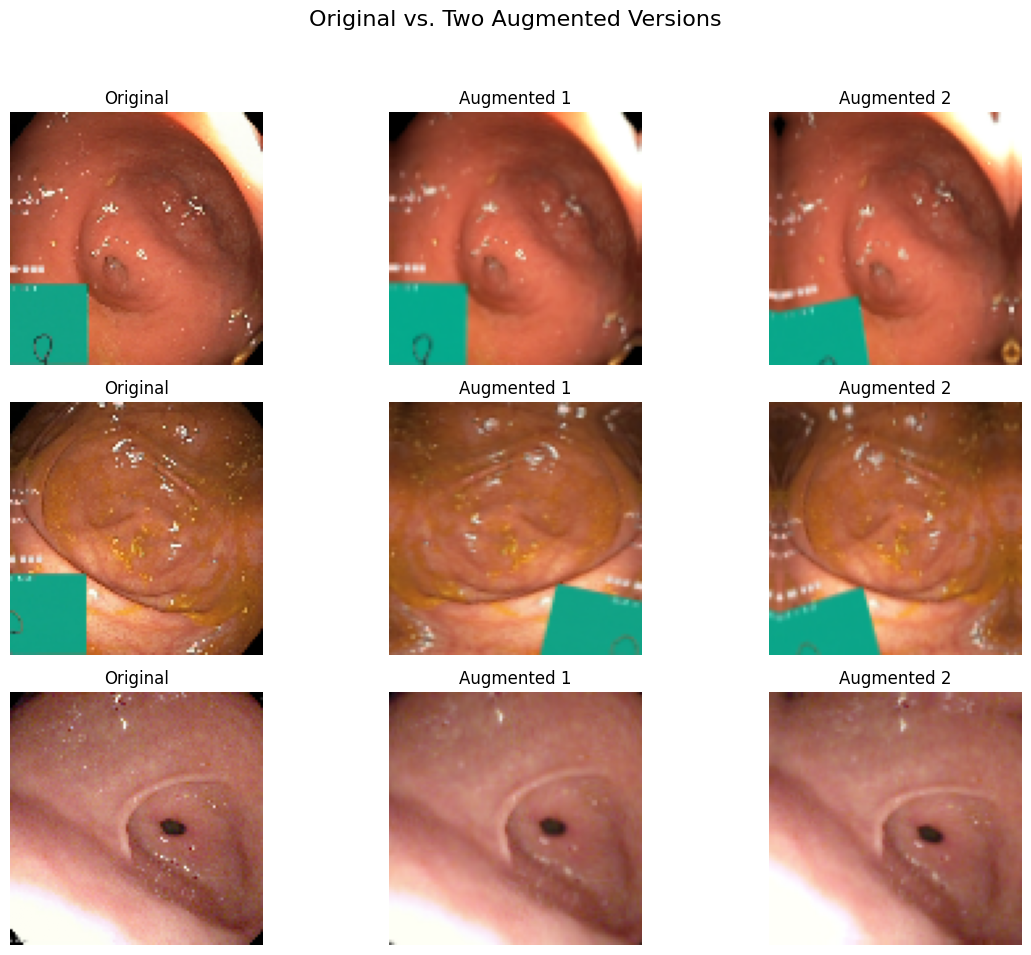

In [ ]:
print("Connecting to Google Drive...")
drive.mount('/content/drive', force_remount=True)

# The source directory of your clean, preprocessed images
source_dir = '/content/drive/MyDrive/EndoVAE_Project/Processed_Data/normal'
local_data_dir = './processed_dataset_final/normal'

print(f"\nChecking for local data at {local_data_dir}...")
if not os.path.exists(local_data_dir):
    print(f"Local data not found. Copying from Google Drive...")
    os.makedirs(os.path.dirname(local_data_dir), exist_ok=True)
    shutil.copytree(source_dir, local_data_dir)
    print(f"✅ Data successfully copied to {local_data_dir}")
else:
    print("✅ Data already exists locally. Skipping copy from Drive.")


num_samples = 3
all_files = glob.glob(os.path.join(local_data_dir, '*.npy'))

if len(all_files) >= num_samples:
    sample_paths = random.sample(all_files, num_samples)
    original_images = np.array([np.load(path) for path in sample_paths])
    print(f"\nLoaded {num_samples} random images for visualization.")
else:
    print(f"❌ Error: Not enough images found in {local_data_dir}")
    raise FileNotFoundError("Could not find enough sample images.")


data_augmentation_pipeline = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.05),
        layers.RandomZoom(height_factor=0.1, width_factor=0.1),
        layers.RandomContrast(factor=0.1),
    ],
    name="data_augmentation",
)

print("Applying augmentation twice to sample images...")
# Call the pipeline once for the first set of augmentations
augmented_images_1 = np.array(data_augmentation_pipeline(original_images, training=True))
# Call it again for a second, different set of augmentations
augmented_images_2 = np.array(data_augmentation_pipeline(original_images, training=True))
print("✅ Augmentation applied.")

fig, axs = plt.subplots(num_samples, 3, figsize=(12, 10))
fig.suptitle("Original vs. Two Augmented Versions", fontsize=16)

for i in range(num_samples):
    # Convert all images in the row from BGR to RGB for display
    org_img_rgb = cv2.cvtColor(original_images[i], cv2.COLOR_BGR2RGB)
    aug_1_rgb = cv2.cvtColor(augmented_images_1[i], cv2.COLOR_BGR2RGB)
    aug_2_rgb = cv2.cvtColor(augmented_images_2[i], cv2.COLOR_BGR2RGB)

    # Plot Original Image
    axs[i, 0].imshow(org_img_rgb)
    axs[i, 0].set_title("Original")
    axs[i, 0].axis('off')

    # Plot First Augmented Image
    axs[i, 1].imshow(aug_1_rgb)
    axs[i, 1].set_title("Augmented 1")
    axs[i, 1].axis('off')

    # Plot Second Augmented Image
    axs[i, 2].imshow(aug_2_rgb)
    axs[i, 2].set_title("Augmented 2")
    axs[i, 2].axis('off')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

### EndoVAE architectural design and Definition of loss functions

In [2]:
class ModelConfig:
    INPUT_SHAPE = (96, 96, 3)
    LATENT_DIM = 6
    LEARNING_RATE = 0.001


def build_encoder(input_shape, latent_dim):
    """Builds the Encoder part of the VAE."""
    encoder_inputs = keras.Input(shape=input_shape)
    x = layers.Conv2D(16, 3, 1, activation="relu", padding="same")(encoder_inputs)
    x = layers.Conv2D(32, 3, 1, activation="relu", padding="same")(x)
    x = layers.Conv2D(32, 3, 2, activation="relu", padding="same")(x)
    x = layers.Conv2D(64, 3, 2, activation="relu", padding="same")(x)
    x = layers.Conv2D(128, 3, 1, activation="relu", padding="same")(x)
    x = layers.Conv2D(256, 3, 2, activation="relu", padding="same")(x)
    x = layers.Flatten()(x)
    x = layers.Dense(256, activation="relu")(x)
    mu = layers.Dense(latent_dim, name="latent_mu")(x)
    log_var = layers.Dense(latent_dim, name="latent_log_var")(x)
    return keras.Model(encoder_inputs, [mu, log_var], name="encoder")

class Sampling(layers.Layer):
    """Custom sampling layer using the reparameterization trick."""
    def call(self, inputs):
        mu, log_var = inputs
        batch = tf.shape(mu)[0]
        dim = tf.shape(mu)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return mu + tf.exp(0.5 * log_var) * epsilon

def build_decoder(latent_dim):
    """Builds the Decoder part of the VAE."""
    latent_inputs = keras.Input(shape=(latent_dim,))
    x = layers.Dense(12 * 12 * 256, activation="relu")(latent_inputs)
    x = layers.Reshape((12, 12, 256))(x)
    x = layers.Conv2DTranspose(256, 3, 2, activation="relu", padding="same")(x)
    x = layers.Conv2D(128, 3, 1, activation="relu", padding="same")(x)
    x = layers.Conv2DTranspose(64, 3, 2, activation="relu", padding="same")(x)
    x = layers.Conv2D(64, 3, 1, activation="relu", padding="same")(x)
    x = layers.Conv2DTranspose(32, 3, 2, activation="relu", padding="same")(x)
    x = layers.Conv2D(32, 3, 1, activation="relu", padding="same")(x)
    decoder_outputs = layers.Conv2D(3, 3, 1, activation="sigmoid", padding="same")(x)
    return keras.Model(latent_inputs, decoder_outputs, name="decoder")


# The "bulletproof" VAE class with full serialization support
class VAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super().__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.sampling = Sampling()
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(name="reconstruction_loss")
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [self.total_loss_tracker, self.reconstruction_loss_tracker, self.kl_loss_tracker]

    def call(self, inputs):
        mu, log_var = self.encoder(inputs)
        z = self.sampling([mu, log_var])
        return self.decoder(z)

    def _calculate_loss(self, data):
        x, y = data
        mu, log_var = self.encoder(x)
        z = self.sampling([mu, log_var])
        reconstruction = self.decoder(z)
        reconstruction_loss = tf.reduce_mean(keras.losses.binary_crossentropy(y, reconstruction))*(96*96)
        kl_loss = -0.5 * (1 + log_var - tf.square(mu) - tf.exp(log_var))
        kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))
        return reconstruction_loss + kl_loss, reconstruction_loss, kl_loss

    def train_step(self, data):
        with tf.GradientTape() as tape:
            total_loss, reconstruction_loss, kl_loss = self._calculate_loss(data)
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {m.name: m.result() for m in self.metrics}

    def test_step(self, data):
        total_loss, reconstruction_loss, kl_loss = self._calculate_loss(data)
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {m.name: m.result() for m in self.metrics}

    # --- KEY ADDITION: Methods for saving and loading ---
    def get_config(self):
        base_config = super().get_config()
        return {
            **base_config,
            "encoder": keras.layers.serialize(self.encoder),
            "decoder": keras.layers.serialize(self.decoder),
        }

    @classmethod
    def from_config(cls, config):
        encoder_config = config.pop("encoder")
        decoder_config = config.pop("decoder")
        encoder = keras.layers.deserialize(encoder_config)
        decoder = keras.layers.deserialize(decoder_config)
        return cls(encoder, decoder, **config)

encoder = build_encoder(ModelConfig.INPUT_SHAPE, ModelConfig.LATENT_DIM)
decoder = build_decoder(ModelConfig.LATENT_DIM)
vae = VAE(encoder, decoder)

optimizer = keras.optimizers.Adam(learning_rate=ModelConfig.LEARNING_RATE , clipnorm=1.0)
# Compile without a loss argument, as it's fully handled inside the class
vae.compile(optimizer=optimizer)
print("✅ Final VAE model built and compiled.")

print("\n" + "="*50)
print("--- Encoder Summary ---")
encoder.summary()
print("\n" + "="*50)
print("--- Decoder Summary ---")
decoder.summary()
print("\n" + "="*50)
print("--- Full VAE Summary (as a Class) ---")
# .summary() is not as informative for subclassed models, but we can build it to see the layers
vae.build((None, *ModelConfig.INPUT_SHAPE))
vae.summary()
print("="*50)

✅ Final VAE model built and compiled.

--- Encoder Summary ---


Model: "encoder"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 96, 96, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 96, 96,    │        448 │ input_layer[0][0] │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 96, 96,    │      4,640 │ conv2d[0][0]      │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 48, 48,    │      9,248 │ conv2d_1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 24, 24,    │     18,496 │ conv2d_2[0][0]    │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 24, 24,    │     73,856 │ conv2d_3[0][0]    │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 12, 12,    │    295,168 │ conv2d_4[0][0]    │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 36864)     │          0 │ conv2d_5[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 256)       │  9,437,440 │ flatten[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ latent_mu (Dense)   │ (None, 6)         │      1,542 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ latent_log_var      │ (None, 6)         │      1,542 │ dense[0][0]       │
│ (Dense)             │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 9,842,380 (37.55 MB)

 Trainable params: 9,842,380 (37.55 MB)

 Non-trainable params: 0 (0.00 B)


--- Decoder Summary ---


Model: "decoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 6)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 36864)          │       258,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 12, 12, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose                │ (None, 24, 24, 256)    │       590,080 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 24, 24, 128)    │       295,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_1              │ (None, 48, 48, 64)     │        73,792 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 48, 48, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_2              │ (None, 96, 96, 32)     │        18,464 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 96, 96, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 96, 96, 3)      │           867 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,282,467 (4.89 MB)

 Trainable params: 1,282,467 (4.89 MB)

 Non-trainable params: 0 (0.00 B)


--- Full VAE Summary (as a Class) ---


/usr/local/lib/python3.11/dist-packages/keras/src/layers/layer.py:393: UserWarning: `build()` was called on layer 'vae', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


Model: "vae"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ encoder (Functional)            │ ((None, 6), (None, 6)) │     9,842,380 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ decoder (Functional)            │ (None, 96, 96, 3)      │     1,282,467 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sampling (Sampling)             │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,124,847 (42.44 MB)

 Trainable params: 11,124,847 (42.44 MB)

 Non-trainable params: 0 (0.00 B)

### Model training process

In [3]:
class TrainingConfig:
    BATCH_SIZE = 128
    EPOCHS = 1000
    VALIDATION_SPLIT = 0.1 # Using 10% of data for validation


gdrive_source_dir = '/content/drive/MyDrive/EndoVAE_Project/Augmented_Dataset/normal'
local_data_dir = './training_data/normal'

print("\nChecking for local data...")
if not os.path.exists(local_data_dir):
    print(f"Local data not found. Copying from Google Drive...")
    shutil.copytree(gdrive_source_dir, local_data_dir)
    print(f"✅ Data successfully copied to {local_data_dir}")
else:
    print("✅ Data already exists locally. Skipping copy.")

print("\nLoading and preparing the dataset...")
npy_files = glob.glob(os.path.join(local_data_dir, '*.npy'))
images = np.array([np.load(fname) for fname in npy_files])

# Create a TensorFlow Dataset in the (input, target) format
dataset = tf.data.Dataset.from_tensor_slices(images)
dataset = dataset.map(lambda x: (x, x))
dataset = dataset.shuffle(buffer_size=len(images), reshuffle_each_iteration=True)

# Create training and validation splits
val_size = int(len(images) * TrainingConfig.VALIDATION_SPLIT)
train_dataset = dataset.skip(val_size)
val_dataset = dataset.take(val_size)

# Batch and prefetch the datasets for performance
train_dataset = train_dataset.batch(TrainingConfig.BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
val_dataset = val_dataset.batch(TrainingConfig.BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
print(f"✅ Dataset prepared.")


print("\nDefining callbacks...")
checkpoint_path = "/content/drive/MyDrive/EndoVAE_Project/best_model_final.keras"

model_checkpoint = keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path,
    save_weights_only=False,
    monitor='val_total_loss',
    mode='min',
    save_best_only=True,
    verbose=1
)
early_stopping = keras.callbacks.EarlyStopping(
    monitor="val_total_loss",
    patience=50,
    verbose=1,
    mode='min',
    restore_best_weights=True
)
reduce_lr = keras.callbacks.ReduceLROnPlateau(
    monitor="val_total_loss",
    factor=0.5,
    patience=10,
    verbose=1,
    min_lr=1e-6
)
callbacks_list = [early_stopping, reduce_lr, model_checkpoint]
print("✅ Callbacks defined.")


# This step assumes the 'vae' model object has been created and compiled by the first code block
print("\n--- Starting Model Training ---")
history = vae.fit(
    train_dataset,
    epochs=TrainingConfig.EPOCHS,
    validation_data=val_dataset,
    callbacks=callbacks_list
)
print("✅ Training finished.")


Checking for local data...
✅ Data already exists locally. Skipping copy.

Loading and preparing the dataset...
✅ Dataset prepared.

Defining callbacks...
✅ Callbacks defined.

--- Starting Model Training ---
Epoch 1/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 737ms/step - kl_loss: 0.5219 - reconstruction_loss: 6248.7173 - total_loss: 6249.2397
Epoch 1: val_total_loss improved from inf to 6046.98193, saving model to /content/drive/MyDrive/EndoVAE_Project/best_model_final.keras
32/32 ━━━━━━━━━━━━━━━━━━━━ 69s 1s/step - kl_loss: 0.5599 - reconstruction_loss: 6245.2451 - total_loss: 6245.8057 - val_kl_loss: 8.7465 - val_reconstruction_loss: 6038.2354 - val_total_loss: 6046.9819 - learning_rate: 0.0010
Epoch 2/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step - kl_loss: 5.6432 - reconstruction_loss: 6011.5068 - total_loss: 6017.1504
Epoch 2: val_total_loss improved from 6046.98193 to 5984.21338, saving model to /content/drive/MyDrive/EndoVAE_Project/best_model_final.keras
32/32 ━━━━━━━━━━━━━━━━━━━━ 8s 2

### generation and reconstruction


Loading the newly trained VAE model...
✅ Model loaded successfully.
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


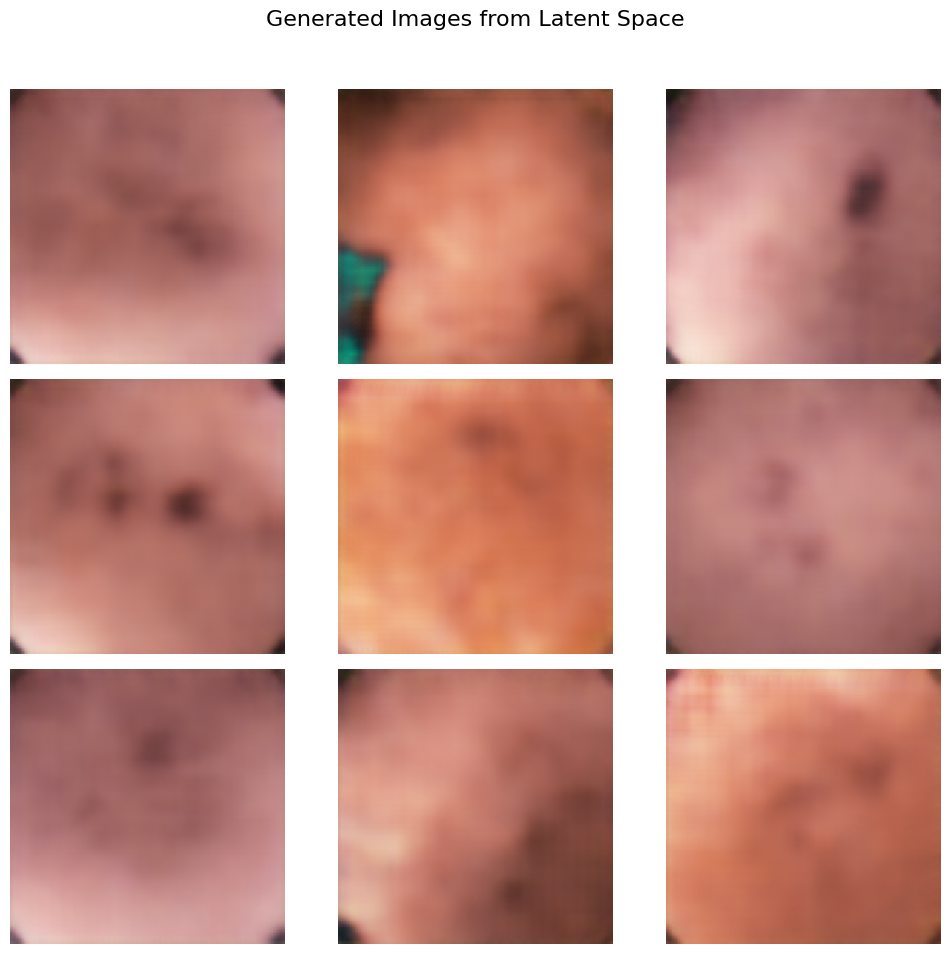

In [4]:
print("\nLoading the newly trained VAE model...")
model_path = "/content/drive/MyDrive/EndoVAE_Project/best_model_final.keras"

if os.path.exists(model_path):
    # Now Keras can correctly deserialize the model using its from_config method
    custom_objects = {"VAE": VAE}
    vae_loaded = keras.models.load_model(model_path, custom_objects=custom_objects)
    decoder = vae_loaded.decoder
    print("✅ Model loaded successfully.")
else:
    print(f"❌ Error: Model file not found. Please re-run training to save the model.")
    raise FileNotFoundError("Model file not found.")


latent_dim = 6
num_images_to_generate = 9
random_latent_vectors = tf.random.normal(shape=(num_images_to_generate, latent_dim))
generated_images = decoder.predict(random_latent_vectors)

plt.figure(figsize=(10, 10))
for i in range(num_images_to_generate):
    plt.subplot(3, 3, i + 1)
    img = generated_images[i]
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(img_rgb)
    plt.axis('off')
plt.suptitle("Generated Images from Latent Space", fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

Connecting to Google Drive...
Mounted at /content/drive

Loading the trained VAE model from Google Drive...
✅ Model loaded successfully.

Loaded 5 random abnormal images for reconstruction.
Reconstructing images using the VAE...
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
✅ Images reconstructed.


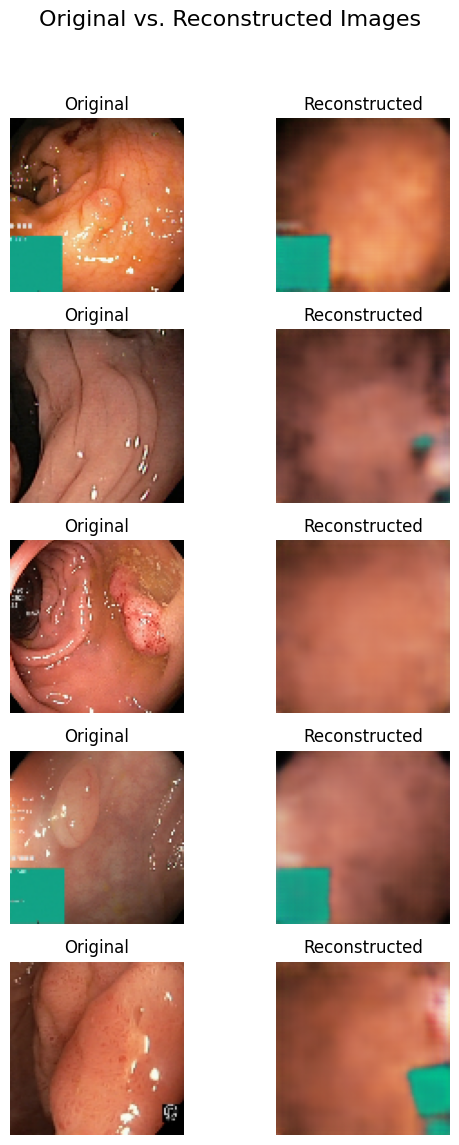

In [5]:
print("Connecting to Google Drive...")
drive.mount('/content/drive', force_remount=True)

# The full VAE class definition must be available during loading.
# This class should be the final, corrected version.
class VAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super().__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.sampling = Sampling()
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(name="reconstruction_loss")
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")

    def call(self, inputs):
        mu, log_var = self.encoder(inputs)
        z = self.sampling([mu, log_var])
        return self.decoder(z)

    # We only need the class structure and call method for inference,
    # but providing the full class definition is safest.
    def get_config(self):
        base_config = super().get_config()
        return {
            **base_config,
            "encoder": keras.layers.serialize(self.encoder),
            "decoder": keras.layers.serialize(self.decoder),
        }

    @classmethod
    def from_config(cls, config):
        encoder_config = config.pop("encoder")
        decoder_config = config.pop("decoder")
        encoder = keras.layers.deserialize(encoder_config)
        decoder = keras.layers.deserialize(decoder_config)
        return cls(encoder, decoder, **config)

class Sampling(layers.Layer):
    def call(self, inputs):
        mu, log_var = inputs
        batch = tf.shape(mu)[0]
        dim = tf.shape(mu)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return mu + tf.exp(0.5 * log_var) * epsilon

print("\nLoading the trained VAE model from Google Drive...")
model_path = "/content/drive/MyDrive/EndoVAE_Project/best_model_final.keras"

if os.path.exists(model_path):
    custom_objects = {"VAE": VAE, "Sampling": Sampling}
    vae_loaded = keras.models.load_model(model_path, custom_objects=custom_objects)
    print("✅ Model loaded successfully.")
else:
    print(f"❌ Error: Model file not found at {model_path}")
    raise FileNotFoundError("Please make sure the model has been trained and saved.")


num_samples = 5
data_dir = '/content/drive/MyDrive/EndoVAE_Project/Processed_Data/abnormal'
all_files = glob.glob(os.path.join(data_dir, '*.npy'))

if len(all_files) >= num_samples:
    sample_paths = random.sample(all_files, num_samples)
    original_images = np.array([np.load(path) for path in sample_paths])
    print(f"\nLoaded {num_samples} random abnormal images for reconstruction.")
else:
    print(f"❌ Error: Not enough images found in {data_dir}")
    raise FileNotFoundError("Could not find enough sample images.")


print("Reconstructing images using the VAE...")
reconstructed_images = vae_loaded.predict(original_images)
print("✅ Images reconstructed.")


fig, axs = plt.subplots(num_samples, 2, figsize=(6, 12))
fig.suptitle("Original vs. Reconstructed Images", fontsize=16)

for i in range(num_samples):
    # Get original and reconstructed images
    org_img = original_images[i]
    rec_img = reconstructed_images[i]

    # Convert from BGR (OpenCV) to RGB (Matplotlib)
    org_img_rgb = cv2.cvtColor(org_img, cv2.COLOR_BGR2RGB)
    rec_img_rgb = cv2.cvtColor(rec_img, cv2.COLOR_BGR2RGB)

    # Plot Original Image
    axs[i, 0].imshow(org_img_rgb)
    axs[i, 0].set_title("Original")
    axs[i, 0].axis('off')

    # Plot Reconstructed Image
    axs[i, 1].imshow(rec_img_rgb)
    axs[i, 1].set_title("Reconstructed")
    axs[i, 1].axis('off')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


Loading the trained VAE model from Google Drive...
✅ Model loaded successfully.

Extracting 5 samples from the validation dataset...
✅ Extracted 5 samples for reconstruction.
Reconstructing images using the VAE...
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


✅ Images reconstructed.


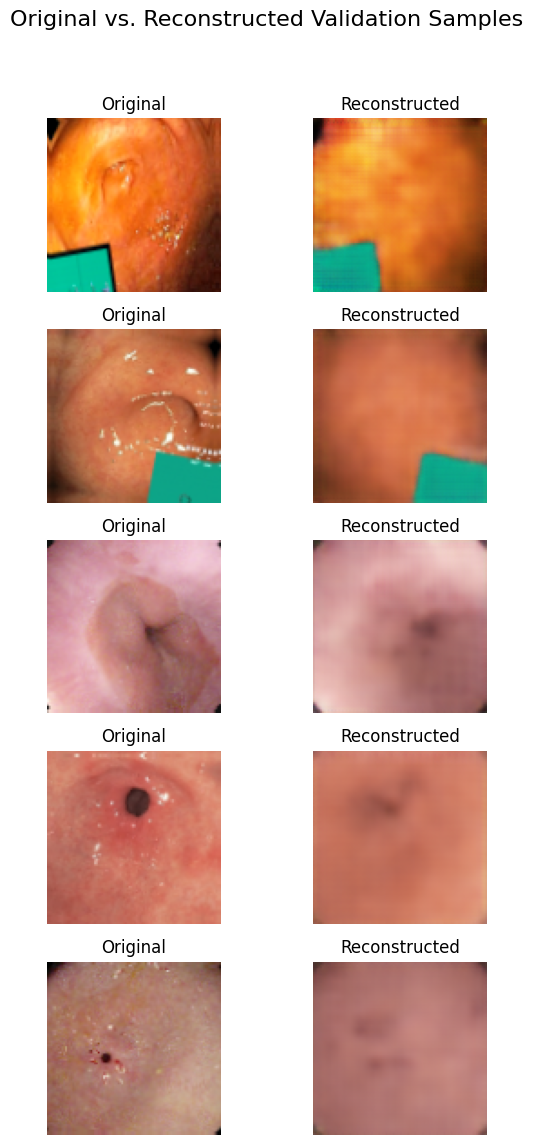

In [6]:
# The full VAE class definition must be available during loading.
class VAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super().__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.sampling = Sampling()
    def call(self, inputs):
        mu, log_var = self.encoder(inputs)
        z = self.sampling([mu, log_var])
        return self.decoder(z)
    def get_config(self):
        base_config = super().get_config()
        return {**base_config, "encoder": keras.layers.serialize(self.encoder), "decoder": keras.layers.serialize(self.decoder)}
    @classmethod
    def from_config(cls, config):
        encoder_config = config.pop("encoder")
        decoder_config = config.pop("decoder")
        encoder = keras.layers.deserialize(encoder_config)
        decoder = keras.layers.deserialize(decoder_config)
        return cls(encoder, decoder, **config)

class Sampling(layers.Layer):
    def call(self, inputs):
        mu, log_var = inputs
        batch = tf.shape(mu)[0]
        dim = tf.shape(mu)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return mu + tf.exp(0.5 * log_var) * epsilon

print("\nLoading the trained VAE model from Google Drive...")
model_path = "/content/drive/MyDrive/EndoVAE_Project/best_model_final.keras"
custom_objects = {"VAE": VAE, "Sampling": Sampling}
vae_loaded = keras.models.load_model(model_path, custom_objects=custom_objects, compile=False)
print("✅ Model loaded successfully.")


print("\nExtracting 5 samples from the validation dataset...")
num_samples = 5

try:
    # Get one batch of data from the validation dataset iterator
    validation_batch = next(iter(val_dataset))

    # The dataset yields tuples of (images, images). We need the first element.
    original_images_batch, _ = validation_batch

    # Take the first 5 images from the batch
    original_images = original_images_batch[:num_samples]

    print(f"✅ Extracted {original_images.shape[0]} samples for reconstruction.")

except NameError:
    print("❌ Error: 'val_dataset' is not defined. Please run the training script's data preparation cell first.")
    raise
except Exception as e:
    print(f"An error occurred: {e}")
    raise

print("Reconstructing images using the VAE...")
reconstructed_images = vae_loaded.predict(original_images)
print("✅ Images reconstructed.")

fig, axs = plt.subplots(num_samples, 2, figsize=(6, 12))
fig.suptitle("Original vs. Reconstructed Validation Samples", fontsize=16)

for i in range(num_samples):
    org_img_rgb = cv2.cvtColor(original_images[i].numpy(), cv2.COLOR_BGR2RGB)
    rec_img_rgb = cv2.cvtColor(reconstructed_images[i], cv2.COLOR_BGR2RGB)

    axs[i, 0].imshow(org_img_rgb)
    axs[i, 0].set_title("Original")
    axs[i, 0].axis('off')

    axs[i, 1].imshow(rec_img_rgb)
    axs[i, 1].set_title("Reconstructed")
    axs[i, 1].axis('off')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

### Numerical evaluation

In [11]:
print("Connecting to Google Drive...")
drive.mount('/content/drive', force_remount=True)

# Keras needs the definition of ALL custom layers/models to load the saved file.
class VAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super().__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.sampling = Sampling()
    def call(self, inputs):
        mu, log_var = self.encoder(inputs)
        z = self.sampling([mu, log_var])
        return self.decoder(z)
    def get_config(self):
        base_config = super().get_config()
        return {**base_config, "encoder": keras.layers.serialize(self.encoder), "decoder": keras.layers.serialize(self.decoder)}
    @classmethod
    def from_config(cls, config):
        encoder_config = config.pop("encoder")
        decoder_config = config.pop("decoder")
        encoder = keras.layers.deserialize(encoder_config)
        decoder = keras.layers.deserialize(decoder_config)
        return cls(encoder, decoder, **config)

class Sampling(layers.Layer):
    def call(self, inputs):
        mu, log_var = inputs
        batch = tf.shape(mu)[0]
        dim = tf.shape(mu)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return mu + tf.exp(0.5 * log_var) * epsilon


print("\nLoading the trained VAE model from Google Drive...")
model_path = "/content/drive/MyDrive/EndoVAE_Project/best_model_final.keras"

if os.path.exists(model_path):
    custom_objects = {"VAE": VAE, "Sampling": Sampling}
    vae_loaded = keras.models.load_model(model_path, custom_objects=custom_objects, compile=False)
    print("✅ Model loaded successfully.")
else:
    print(f"❌ Error: Model file not found at {model_path}")
    raise FileNotFoundError("Please make sure the model path is correct.")

num_samples = 50
data_dir = '/content/drive/MyDrive/EndoVAE_Project/Processed_Data/abnormal'
all_files = glob.glob(os.path.join(data_dir, '*.npy'))

if len(all_files) >= num_samples:
    sample_paths = random.sample(all_files, num_samples)
    original_images = np.array([np.load(path) for path in sample_paths])
    print(f"\nLoaded {num_samples} random abnormal images for evaluation.")
else:
    print(f"❌ Error: Not enough images found in {data_dir}")
    raise FileNotFoundError("Could not find enough sample images.")

print("Reconstructing images using the VAE...")
reconstructed_images = vae_loaded.predict(original_images)
print("✅ Images reconstructed.")

print("Calculating SSIM and PSNR metrics...")
ssim_scores = []
psnr_scores = []

for i in range(num_samples):
    original_img_tensor = tf.convert_to_tensor(original_images[i], dtype=tf.float32)
    reconstructed_img_tensor = tf.convert_to_tensor(reconstructed_images[i], dtype=tf.float32)

    # Calculate PSNR
    # max_val=1.0 because our images are normalized to [0, 1]
    psnr = tf.image.psnr(original_img_tensor, reconstructed_img_tensor, max_val=1.0)
    psnr_scores.append(psnr.numpy())

    # Calculate SSIM
    ssim = tf.image.ssim(original_img_tensor, reconstructed_img_tensor, max_val=1.0)
    ssim_scores.append(ssim.numpy())

print("✅ Metrics calculated.")


results = {
    "Metric": ["SSIM", "PSNR"],
    "Mean": [np.mean(ssim_scores), np.mean(psnr_scores)],
    "Std Dev": [np.std(ssim_scores), np.std(psnr_scores)]
}

# Create and display a pandas DataFrame
df_results = pd.DataFrame(results)
print("\n--- Evaluation Results ---")
print(df_results.to_string(index=False))

Connecting to Google Drive...
Mounted at /content/drive

Loading the trained VAE model from Google Drive...
✅ Model loaded successfully.

Loaded 50 random abnormal images for evaluation.
Reconstructing images using the VAE...
2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 2s/step
✅ Images reconstructed.
Calculating SSIM and PSNR metrics...
✅ Metrics calculated.

--- Evaluation Results ---
Metric      Mean  Std Dev
  SSIM  0.424002 0.099547
  PSNR 17.162870 2.372506
